In [1]:
import re
import os
import boto3
import configparser

import numpy as np
import pandas as pd
import dask.dataframe as dd
from sqlalchemy import create_engine

import geopandas
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
config = configparser.ConfigParser()
config.read_file(open('/Users/danieldiamond/.aws/credentials'))
CAPSTONE_AWS_ACCESS_KEY_ID = config.get('capstone', 'AWS_ACCESS_KEY_ID')
CAPSTONE_AWS_SECRET_ACCESS_KEY = config.get('capstone', 'AWS_SECRET_ACCESS_KEY')

In [3]:
s3_creds = {'region_name':"us-east-1",
            'aws_access_key_id': CAPSTONE_AWS_ACCESS_KEY_ID,
            'aws_secret_access_key': CAPSTONE_AWS_SECRET_ACCESS_KEY}
                          
client = boto3.client('s3', **s3_creds)
resource = boto3.resource('s3', **s3_creds)
bucket = resource.Bucket('us-immigration')

### Step 1: Scope the Project and Gather Data

#### Scope 
The purpose of this project is to provide a deep dive into US immigration, primiarily focusing on the type of visas being issued and the profiles associated. The scope of this project is limited to the data sources listed below with data being aggregated across numerous features such as visatype, gender, port_of_entry, nationality and month.

#### Data Description & Sources 
- I94 Immigration Data: This data comes from the US National Tourism and Trade Office found [here](https://travel.trade.gov/research/reports/i94/historical/2016.html). Each report contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries).
- World Temperature Data: This dataset came from Kaggle found [here](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data).
- U.S. City Demographic Data: This dataset contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. Dataset comes from OpenSoft found [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
- Airport Code Table: This is a simple table of airport codes and corresponding cities. The airport codes may refer to either IATA airport code, a three-letter code which is used in passenger reservation, ticketing and baggage-handling systems, or the ICAO airport code which is a four letter code used by ATC systems and for airports that do not have an IATA airport code (from wikipedia). It comes from [here](https://datahub.io/core/airport-codes#data).

In [17]:
bucket = resource.Bucket('us-immigration')
csv_files = [o.key for o in bucket.objects.all() if '.csv' in o.key]
parquet_files = [o.key for o in bucket.objects.all() if '.parquet' in o.key]

print(f"{len(csv_files)} csv files")
print(f"{len(parquet_files)} parquet files")

13 csv files
14 parquet files


In [18]:
csv_files.remove('global_land_temp_by_cities.csv')

In [19]:
csv_files

['airport_codes.csv',
 'i94addr.csv',
 'i94cit_i94res.csv',
 'i94mode.csv',
 'i94port.csv',
 'i94visa.csv',
 'immigration_data_sample.csv',
 'nationality_codes.csv',
 'port_of_entry_codes.csv',
 'port_of_issue_codes.csv',
 'us_cities_demographics.csv',
 'visa_codes.csv']

In [20]:
data = {}
for file in csv_files:
    data[file.replace('.csv', '')] = pd.read_csv(client.get_object(Bucket='us-immigration', Key=file)['Body'])

In [62]:
for k,v in data.items():
    k
    v.head()

'airport_codes'

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,lat,long
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125",40.070801,-74.933601
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022",38.704022,-101.473911
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968",59.949200,-151.695999
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172",34.864799,-86.770302
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087",35.608700,-91.254898


'i94addr'

,code,state
0,AL,Alabama
1,AK,Alaska
2,AZ,Arizona
3,AR,Arkansas
4,CA,California


'i94cit_i94res'

,code,country
0,582,"Mexico Air Sea, And Not Reported (I-94, No Lan..."
1,236,Afghanistan
2,101,Albania
3,316,Algeria
4,102,Andorra


'i94mode'

,code,transportation
0,1,Air
1,2,Sea
2,3,Land


'i94port'

,code,port_of_entry,city,state_or_country
0,ALC,"Alcan, Ak",Alcan,Ak
1,ANC,"Anchorage, Ak",Anchorage,Ak
2,BAR,"Baker Aaf - Baker Island, Ak",Baker Aaf - Baker Island,Ak
3,DAC,"Daltons Cache, Ak",Daltons Cache,Ak
4,PIZ,"Dew Station Pt Lay Dew, Ak",Dew Station Pt Lay Dew,Ak


'i94visa'

,code,reason_for_travel
0,1,Business
1,2,Pleasure
2,3,Student


'immigration_data_sample'

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


'nationality_codes'

,nationality,code
0,Afghanistan,AFGH
1,Algeria,ALGR
2,Angola,ANGL
3,Argentina,ARG
4,Australia,ASTL


'port_of_entry_codes'

,code,location,city,state_or_country
0,ABE,"Aberdeen, WA",Aberdeen,WA
1,ABQ,"Albuquerque, NM",Albuquerque,NM
2,ADT,"Amistad Dam, TX",Amistad Dam,TX
3,ALP,"Alpena, MI",Alpena,MI
4,AGN,"Algonac, MI",Algonac,MI


'port_of_issue_codes'

,port_of_issue,code
0,Abidjan,ABJ
1,Abu Dhabi (Beirut Files),BRF (used for IV only)
2,Accra,ACC
3,Alexandria,ALX
4,Almaty,ATA


'us_cities_demographics'

,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,race,count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


'visa_codes'

,class_of_admission,ins_status_code,description,section_of_law
0,203(a)(7),RE,Conditional Entrant,Pursuant to Section 203(a)(7) of the INA
1,207/Refugee,RF,Refugee,Pursuant to Section 207 of the INA
2,208,AS,Asylee,Pursuant to Section 208 of the INA
3,243(h) or 241(b)(3),DW,Withholding of deportation or removal,Pursuant to Section 243(h) or 241(b)(3)
4,"AM 1,2,3",AM,Amerasian,Amerasian


In [65]:
data['immigration_data_sample'].merge(data['visa_codes'], left_on='visatype', right_on='class_of_admission'
                                     ).groupby(['gender','visatype'])[['cicid']].count()

cicid
gender visatype       
F      B1           10
       B2          163
       CP            3
       F1            6
       F2            1
       WB           12
       WT          184
M      B1           47
       B2          167
       CP            2
       E2            3
       F1            4
       F2            2
       M1            1
       WB           44
       WT          182
X      WT            1

#### Airport Data
-------------------------------------------

In [26]:
data['airport_codes'].head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,lat,long
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125",40.070801,-74.933601
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022",38.704022,-101.473911
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968",59.949200,-151.695999
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172",34.864799,-86.770302
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087",35.608700,-91.254898


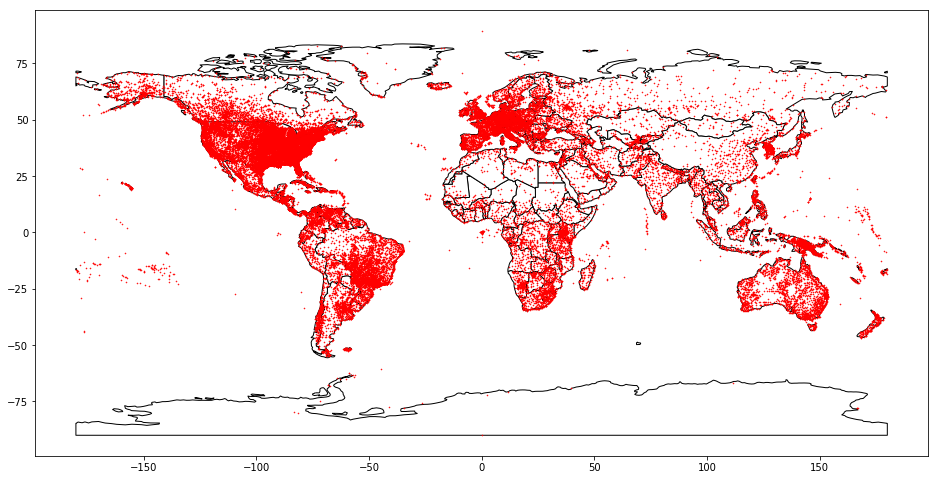

In [217]:
gdf = geopandas.GeoDataFrame(
    data['airport_codes'][['long','lat']], 
    geometry=geopandas.points_from_xy(data['airport_codes'].long, 
                                      data['airport_codes'].lat))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(color='white', edgecolor='black', figsize=(16,12))

gdf.plot(ax=ax, color='red', markersize=0.3)

plt.show();

#### Cities Data
-------------------------------------------

In [27]:
data['us_cities_demographics'].shape

(2891, 12)

In [28]:
data['us_cities_demographics'].head()

,city,state,median_age,male_population,female_population,total_population,number_of_veterans,foreign_born,average_household_size,state_code,race,count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Immigration Data
-------------------------------------------

<img src="./images/dask.png" align="left">

In [29]:
df = dd.read_parquet('s3://us-immigration/parquet_data/*',
                     storage_options={"profile_name":"capstone"})


In [30]:
df.compute().shape

(3096313, 28)

In [33]:
df.head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


- i94yr: 4 digit year
- i94mon: numeric month
- i94cit & i94res: valid & invalid codes for processing
- i94port: valid & invalid codes for processing
- arrdate: arrival date in USA. SAS date numeric field.
- i94mode: 1 = 'Air', 2 = 'Sea', 3 = 'Land', 9 = 'Not Reported'
- i94addr: 
- i94bir: age of respondent in years
- i94 visa: visa code, 1 = 'Business', 2 = 'Pleasure', 3 = 'Student'
- count: summary statistics
- dtadfile: character date field
- visapost: department of state where visa was issued
- occup: occupation performed in the U.S.
- entdepa: arrival flag - admitted or paroled into the U.S.
- entdepu: update flag - apprehended or overstayed, adjusted to perm residence
- matflag: match flag - match of arrival and departure records
- biryear: 4 digit year of birth
- dtaddto: chracter date field - date to which admitted to U.S.
- gender
- insnum: INS number
- airline: airline sued to arrive in U.S.
- admnum - admission number
- fltnoL flight number of airline used to arrive in U.S.
- visatype: class of admission legally admitting the non-immigrant to temporarily stay in U.S.

In [34]:
df.groupby(['gender','visatype'])[['cicid']].agg({'count': 'count'}).compute()

count
gender visatype        
F      B1         47044
       B2        563894
       CP          7978
       CPL            1
       E1           981
       E2          5495
       F1         18205
       F2          1696
       GMB           48
       GMT        47017
       I            875
       I1            65
       M1           302
       M2            41
       SBP            1
       WB         38320
       WT        570780
M      B1        145205
       B2        471315
       CP          6335
       CPL            9
       E1          2761
       E2         13882
       F1         20806
       F2          1288
       GMB          102
       GMT        41521
       I           2301
       I1           169
       M1          1014
       M2             8
       SBP           10
       WB        150299
       WT        520199
U      B1            39
       B2           213
       CP            32
       F1             1
       GMT           65
       WB             2
       WT           115
X      B1            37
       B2           104
       CP           412
       F1             1
       GMT          530
       WB             6
       WT           520

### Step 2: Preprocessing Data
Note: preprocessing was performed prior to storing CSV files in S3 buckets i.e. converting expanding columns, Capitalizing/Lowercasing test etc.
#### Explore Data 
- Identify missing values
- Identify duplicate values

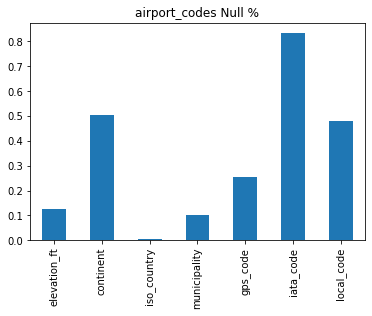

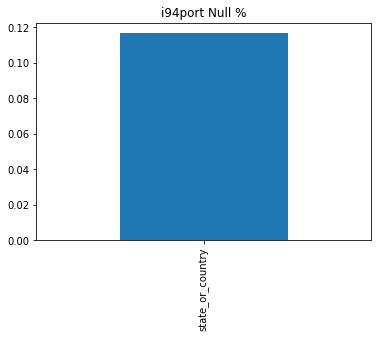

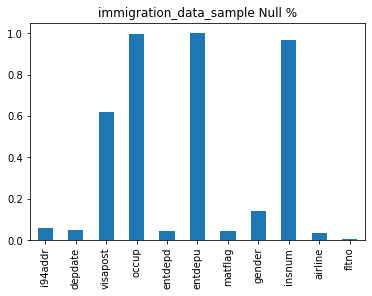

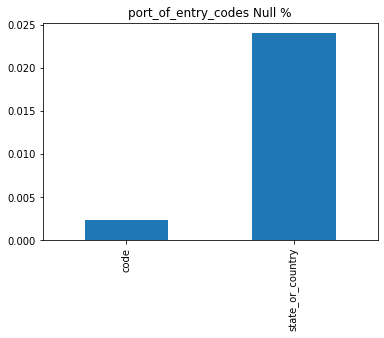

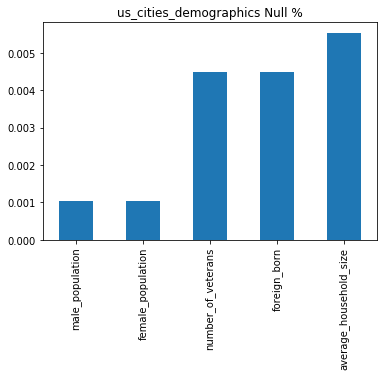

In [97]:
for k,v in data.items():
    null_count = v.isnull().sum()
    if null_count.sum()>0:
        ax = (null_count[null_count>0]/v.shape[0]).plot(kind='bar', title=f"{k} Null %")
        plt.show()

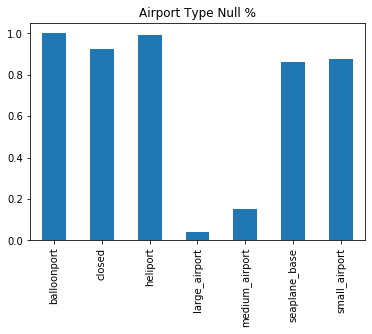

In [95]:
ax = (data['airport_codes'][data['airport_codes'].iata_code.isnull()].type.value_counts()/
      data['airport_codes'].type.value_counts()).plot(kind='bar', title=f"Airport Type Null %")

The above provides further insight into the majority of null values in the airport data. Specifically, majority of null values associated with airport data stem from missing `iata_codes`. Upon further investigation it appears that the lesser important airports associated with immigration, namely, `balloon ports, closed, heliports, seaplanes and small airports` do not have corresponding `iata_codes` information.

#### Cleaning Steps
- Either drop rows or fill missing data with median values where appropriate
- Expand coordinates to Latitude & Longitude columns
- Expand locations to City & State columns
e.g. the data provided for `port_of_entry_codes` was originally `code` and `location`. These have subsequently been expanded out to `city` and `state_or_country` as shown below:

In [109]:
data['port_of_entry_codes'][['code', 'location']].head()

,code,location
0,ABE,"Aberdeen, WA"
1,ABQ,"Albuquerque, NM"
2,ADT,"Amistad Dam, TX"
3,ALP,"Alpena, MI"
4,AGN,"Algonac, MI"


In [107]:
pd.DataFrame(data['port_of_entry_codes']['location'].head().str.split(',').tolist(), columns=['city', 'state'])

,city,state
0,Aberdeen,WA
1,Albuquerque,NM
2,Amistad Dam,TX
3,Alpena,MI
4,Algonac,MI


### Step 3: Data Model
<img src="./images/schema.png"/>

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Creating the data model involves various steps, which can be made significantly easier through the use of Airflow. The process of extracting files from S3 buckets, transforming the data and then writing CSV and PARQUET files to Redshift is accomplished through various tasks highlighted below in the ETL Dag graph. These steps include:
- Extracting data from SAS Documents and writing as CSV files to S3 immigration bucket
- Extracting remaining CSV and PARQUET files from S3 immigration bucket
- Writing CSV and PARQUET files from S3 to Redshift
- Performing data quality checks on the newly created tables
<img src="./images/dag_graph.png"/>

#### 4.2 Data Quality Checks
Data quality checks include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness

#### Check Tables

In [ ]:
REDSHIFT_USER = os.environ.get('CAPSTONE_REDSHIFT_USER')
REDSHIFT_PWD = os.environ.get('CAPSTONE_REDSHIFT_PASSWORD')
REDSHIFT_HOST = os.environ.get('CAPSTONE_HOST')
REDSHIFT_PORT = os.environ.get('CAPSTONE_PORT')
REDSHIFT_DB = os.environ.get('CAPSTONE_DB')

from sqlalchemy import create_engine
eng = create_engine(f'postgres://{REDSHIFT_USER}:{REDSHIFT_PWD}@{REDSHIFT_HOST}:{REDSHIFT_PORT}/{REDSHIFT_DB}')

In [152]:
qry = eng.execute("""
SELECT TABLE_NAME
FROM INFORMATION_SCHEMA.TABLES
WHERE TABLE_TYPE = 'BASE TABLE' AND TABLE_CATALOG='dev'
""")
tables = pd.DataFrame([{**row} for row in qry]).tail(12)
tables

,table_name
150,immigration
151,airport_codes
152,port_of_entry_codes
153,nationality_codes
154,port_of_issue_codes
155,visa_codes
156,us_cities_demographics
157,i94cit_i94res
158,i94port
159,i94mode


In [154]:
qry = eng.execute("""select * from visa_codes limit 5;""")
pd.DataFrame([{**row} for row in qry])

,class_of_admission,description,ins_status_code,section_of_law
0,203(a)(7),Conditional Entrant,RE,Pursuant to Section 203(a)(7) of the INA
1,207/Refugee,Refugee,RF,Pursuant to Section 207 of the INA
2,208,Asylee,AS,Pursuant to Section 208 of the INA
3,243(h) or 241(b)(3),Withholding of deportation or removal,DW,Pursuant to Section 243(h) or 241(b)(3)
4,"AM 1,2,3",Amerasian,AM,Amerasian


#### Check Distinct Rows

In [186]:
def get_col_from_table(table, col=0):
    qry = eng.execute(f"select * from {table} limit 1;")
    return pd.DataFrame([{**row} for row in qry]).columns[col]

In [194]:
for table in tables['table_name'][1:]:
    column = get_col_from_table(table)
    sql = f"SELECT COUNT(DISTINCT {column}) FROM {table};"
    c = eng.execute(sql).fetchone()[0]
    print(f"{table}:\n\t{c} distinct rows for column {column}\n")

airport_codes:
	7 distinct rows for column continent

port_of_entry_codes:
	389 distinct rows for column city

nationality_codes:
	202 distinct rows for column code

port_of_issue_codes:
	284 distinct rows for column code

visa_codes:
	104 distinct rows for column class_of_admission

us_cities_demographics:
	161 distinct rows for column average_household_size

i94cit_i94res:
	288 distinct rows for column code

i94port:
	634 distinct rows for column city

i94mode:
	3 distinct rows for column code

i94addr:
	54 distinct rows for column code

i94visa:
	3 distinct rows for column code



#### Basic Study of Visa Counts by Gender

In [123]:
qry = eng.execute("""
SELECT 
    im.gender, 
    im.visatype,
    count(im.cicid) 
FROM immigration as im 
    JOIN visa_codes 
    ON im.visatype = visa_codes.class_of_admission 
GROUP BY im.gender, im.visatype
""")

qry_df = pd.DataFrame([{**row} for row in qry])

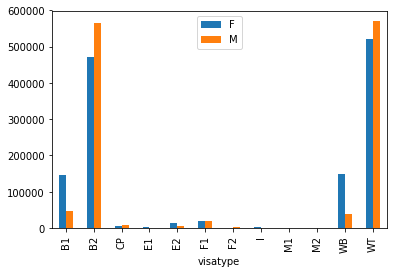

In [134]:
df = qry_df.set_index(['visatype', 'gender']).unstack()[[('count', 'M'),('count', 'F')]]
df.columns=['F', 'M']
df.plot(kind='bar');